# Predicción del uso de bicicletas

El uso compartido de bicicletas es un servicio proporcionado por cualquier ciudad importante del mundo, por lo que comprender y predecir el comportamiento del sistema es un elemento clave. Vamos a trabajar con el conjunto de datos de bicicletas compartidas del repositorio de conjuntos de datos de UCI que recopila estadísticas agregadas de uso de bicicletas junto con otra información adicional relevante. Se pueden descargar los datos desde aquí https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset. El objetivo de este problema es predecir cuántas bicicletas se usarán diariamente (el archivo day.csv). Podéis leer en el Readme.txt los detalles sobre las variables.

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.regressor import prediction_error

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, PoissonRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config
from sklearn.decomposition import PCA

from yellowbrick.regressor import AlphaSelection

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

import warnings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

set_config(display='text')
warnings.filterwarnings('ignore')

sns.set()
sns.set_theme(style="ticks", palette=None)
pd.set_option('display.precision', 3)


**a) El primer paso es preprocesar y preparar los datos antes de ajustar cualquier modelo. Hay
algunas variables que no son útiles para el problema o que no tiene sentido usar. Eliminad las del conjunto de datos. Dividid los datos en conjuntos de entrenamiento y test (60 %
/40 %). Haced una exploración mínima del conjunto de datos de entrenamiento observando las relaciones entre las variables, especialmente con la variable objetivo. Describid las
cosas que hayáis visto que os parezcan interesantes. Estandarizad las variables (calculad
el estandarizador a partir de los datos del entrenamiento y luego aplicadlo a los datos de
test).**

* Empezamos descargando el conjunto de datos con el que queremos trabajar:

In [2]:
import requests, zipfile, io

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
response = requests.get(url, stream=True)
zipfile = zipfile.ZipFile(io.BytesIO(response.content))

zipfile.extractall("dataBici")

In [3]:
day_data = pd.read_csv("dataBici/day.csv", header=0)

day_data = day_data.rename(columns={'dteday':'fecha','season':'estación','yr':'año','mnth':'mes','holiday':'festivo','weekday':'dia_semana','workingday':'lectivo','weathersit':'tiempo','temp':'temperatura','atemp':'sensación_térmica','hum':'humedad','windspeed':'vel_viento','casual':'usuarios_casuales','registered':'usuarios_registrados','cnt':'usuarios_totales','':'',})
day_data.head()

,instant,fecha,estación,año,mes,festivo,dia_semana,lectivo,tiempo,temperatura,sensación_térmica,humedad,vel_viento,usuarios_casuales,usuarios_registrados,usuarios_totales
0,1,2011-01-01,1,0,1,0,6,0,2,0.344,0.364,0.806,0.160,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363,0.354,0.696,0.249,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196,0.189,0.437,0.248,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200,0.212,0.590,0.160,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.227,0.229,0.437,0.187,82,1518,1600


In [4]:
## Dropeamos las columnas que creemos que no son relevantes
day_data.drop(columns=['instant'], inplace=True)
day_data.drop(columns=['fecha'], inplace=True)

## Los que se pueden inferir de otros datos
day_data.drop(columns=['lectivo'], inplace=True) ## si no es festivo i dia entre 1-5 ->lectivo
day_data.drop(columns=['sensación_térmica'], inplace=True) ##derivada de la temp, el viento y la humedad

## Estas literalmente nos dan los usuarios totales
day_data.drop(columns=['usuarios_casuales'], inplace=True)
day_data.drop(columns=['usuarios_registrados'], inplace=True)

day_data.head()

,estación,año,mes,festivo,dia_semana,tiempo,temperatura,humedad,vel_viento,usuarios_totales
0,1,0,1,0,6,2,0.344,0.806,0.160,985
1,1,0,1,0,0,2,0.363,0.696,0.249,801
2,1,0,1,0,1,1,0.196,0.437,0.248,1349
3,1,0,1,0,2,1,0.200,0.590,0.160,1562
4,1,0,1,0,3,1,0.227,0.437,0.187,1600


In [5]:
day_data.isna().sum()
## Parece que no tenemos valores perdidos

estación            0
año                 0
mes                 0
festivo             0
dia_semana          0
tiempo              0
temperatura         0
humedad             0
vel_viento          0
usuarios_totales    0
dtype: int64

In [6]:
X = day_data.loc[:,day_data.columns != 'usuarios_totales']
y = day_data['usuarios_totales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [7]:
## En este caso los datos ya estan normaliados, asi que para la representación de los datos vamos a transformarlos en sus valores originales
grafica = X_train.copy()
grafica['estación'] = grafica['estación'].astype('category')
grafica['año'] = grafica['año'].astype('category')
grafica['mes'] = grafica['mes'].astype('category')
grafica['dia_semana'] = grafica['dia_semana'].astype('category')
grafica['festivo'] = grafica['festivo'].astype('category')
grafica['tiempo'] = grafica['tiempo'].astype('category')
grafica['temperatura'] *= 41
grafica['humedad'] *= 100
grafica['vel_viento'] *= 67
grafica.head()

,estación,año,mes,festivo,dia_semana,tiempo,temperatura,humedad,vel_viento
329,4,0,11,0,6,1,15.409,68.167,4.584
153,2,0,6,0,5,1,25.420,35.417,16.959
75,1,0,3,0,4,1,17.015,60.292,14.042
377,1,1,1,0,5,1,11.241,50.750,25.333
277,4,0,10,0,3,1,22.072,64.792,11.876


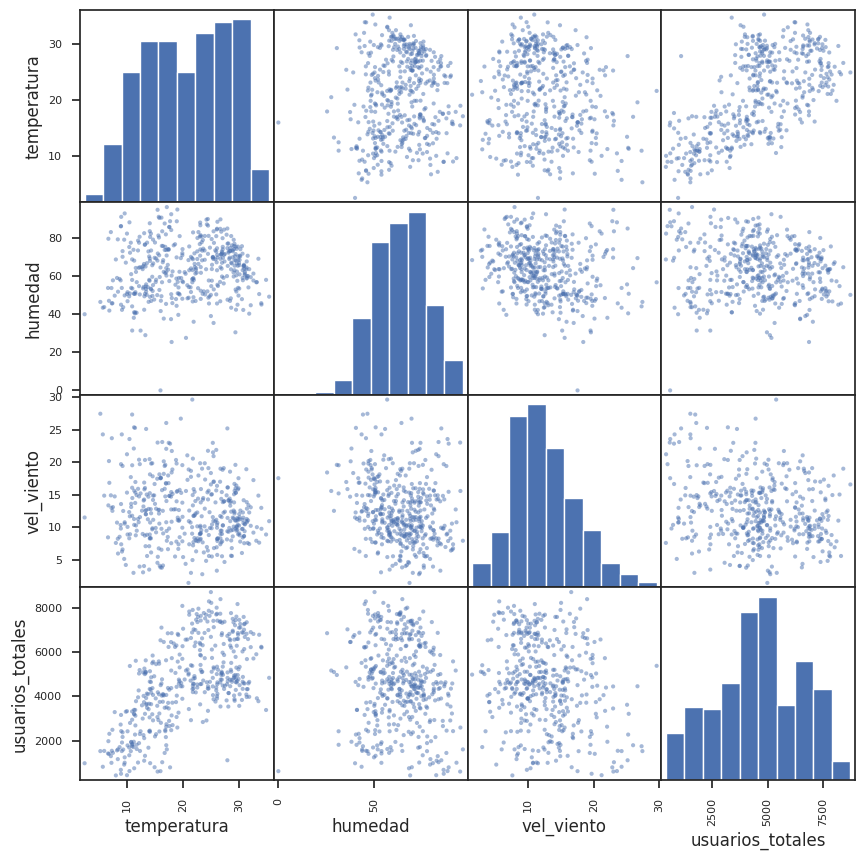

In [8]:
grafica2=grafica.copy()
grafica2.insert(0,'usuarios_totales', y_train)
scatter_matrix(grafica2.loc[:,['temperatura', 'humedad', 'vel_viento', 'usuarios_totales']],figsize=(10,10));

* Vemos que los datos meteorológicos menos la temperatura siguen una distribución bastante parecida a una normal, solo que un poco desplazada. Podemos ver que la mayoría de días hace buen tiempo y que seguramente los días con lluvia/nieve intensa ni siquiera abren la tienda. Los datos respecto a los días cumplen lo esperado. Podemos ver una correlación positiva entre la temperatura y el número de usuarios.

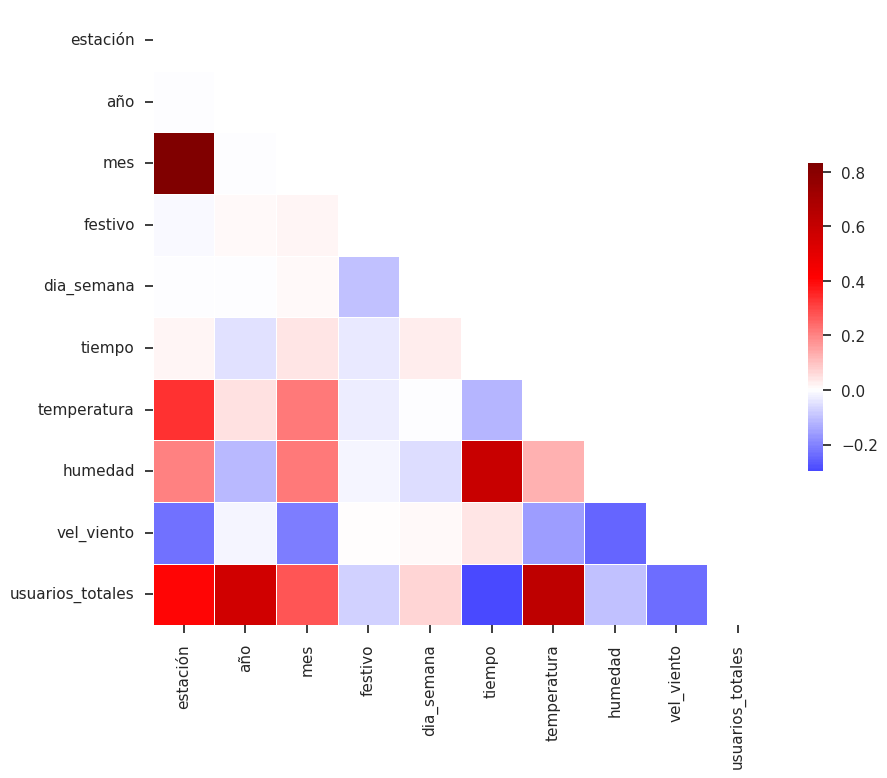

In [9]:
corr = day_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

* Podemos ver claramente en la matriz de correlación que los parámetros que más afectan de forma positiva al número total de usuarios son la temperatura (a mayor temperatura más usuarios) que va fuertemente ligada a la estación y mes en el que estamos, y el año (el segundo año parece tener más usuarios que el primero)
<br>
<br>
* También tenemos con correlación negativa al número de usuarios el tiempo (números pequeños significan mejor tiempo, por tanto, a cuanto peor sea el tiempo, menos usuarios) y el viento(más usuarios en los días sin viento). 

In [10]:
# Preprocessing function
def categorical_preprocessing(X, y,scaler=None):
    categorical_columns =X.dtypes[X.dtypes == 'category'].index.values
    numerical_columns = [c for c in X.columns if c not in categorical_columns]
    
    # Escale numeric variables
    if scaler is None: 
        # Scaler
        scaler = MinMaxScaler()
        X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
    else: 
        X[numerical_columns] = scaler.transform(X[numerical_columns])
    

    return X, y, scaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)
X_train, y_train, scaler = categorical_preprocessing(X_train,y_train)
X_test, y_test, _ = categorical_preprocessing(X_test,y_test,scaler)

X_train.head()

,estación,año,mes,festivo,dia_semana,tiempo,temperatura,humedad,vel_viento
329,1.000,0.0,0.909,0.0,1.000,0.0,0.395,0.708,0.110
153,0.333,0.0,0.455,0.0,0.833,0.0,0.699,0.368,0.550
75,0.000,0.0,0.182,0.0,0.667,0.0,0.443,0.626,0.447
377,0.000,1.0,0.000,0.0,0.833,0.0,0.268,0.527,0.849
277,1.000,0.0,0.818,0.0,0.500,0.0,0.597,0.673,0.369


**b) Aplicad algún método de reducción de dimensionalidad a los datos de entrenamiento y
comentad lo que se pueda apreciar en la visualización. Pensad en qué podéis representar
sobre la transformación.**

In [11]:
data_columns = ['estación','año','mes','festivo','dia_semana','tiempo','temperatura','humedad','vel_viento']
d_standarized = X_train.copy()
d_standarized[data_columns] = StandardScaler().fit_transform(X_train[data_columns])
d_standarized.describe().T

,count,mean,std,min,25%,50%,75%,max
estación,438.0,9.328e-17,1.001,-1.382,-0.470,0.441,0.441,1.352
año,438.0,-1.622e-17,1.001,-1.037,-1.037,0.964,0.964,0.964
mes,438.0,-1.501e-16,1.001,-1.645,-0.763,0.119,0.927,1.589
festivo,438.0,-3.244e-17,1.001,-0.168,-0.168,-0.168,-0.168,5.958
dia_semana,438.0,2.129e-17,1.001,-1.461,-0.972,0.007,0.985,1.474
tiempo,438.0,1.622e-17,1.001,-0.738,-0.738,-0.738,1.120,2.978
temperatura,438.0,-1.075e-16,1.001,-2.481,-0.870,0.109,0.864,1.988
humedad,438.0,9.287e-16,1.001,-4.569,-0.735,0.044,0.703,2.332
vel_viento,438.0,-4.461e-17,1.001,-2.251,-0.720,-0.161,0.583,3.452


In [12]:
myPCA = PCA().fit(d_standarized[data_columns]);

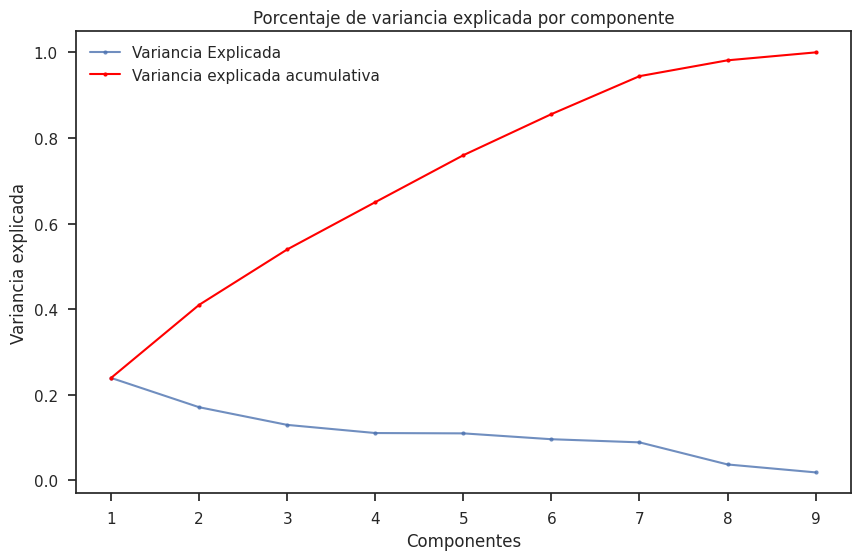

In [13]:
fig = plt.figure(figsize=(10,6));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
     np.cumsum(myPCA.explained_variance_ratio_),
     c='red',marker='.',
     label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

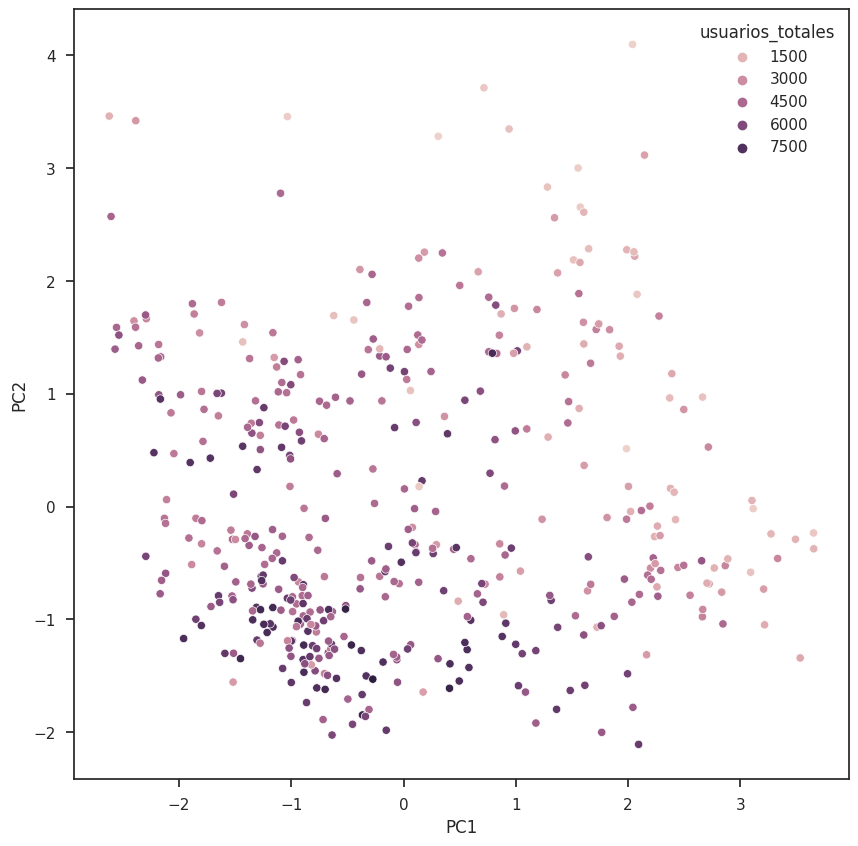

In [14]:
transformed = myPCA.transform(d_standarized[data_columns])
d_standarized[['PC1','PC2']] = transformed[:,:2]
fig = plt.figure(figsize=(10,10))
_ = sns.scatterplot(x='PC1', y='PC2', hue=y_train ,data=d_standarized)

* Tal como nos indica el PCA, necesitamos de todas las variables para explicar la variancia. En la representación en 2D, podemos ver como no hay separabilidad entre los datos. Era de esperar ningún grupo reducido de componentes nos bastara para explicar la mayor parte de la variancia, ya que estamos trabajando con 9 dimensiones que ya es un numero reducido de base.

**c) La variable a predecir es un conteo. En este caso podría tener sentido utilizar un regresor que use un modelo adecuado para este tipo de datos como el PoissonRegressor de
scikit-learn. Veréis que tiene un parámetro de regularización alpha que necesitaréis ajustar usando validación cruzada. Con el mejor parámetro de regularización según el error de
validación cruzada, ajustad el modelo con los datos de entrenamiento y calculad la calidad
del modelo con los datos de test.**

In [15]:
cross_val_metrics = pd.DataFrame(columns=['mean MSE', 'mean norm_MSE', 'mean R2'])
alphas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
# Calculamos las metricas de validación cruzada para cada lambda
for alpha_val in alphas:
    kf = KFold(n_splits=5)
    i=1
    cv_mse = []
    cv_nmse = []
    cv_r2 = []
    # Calculamos la metrica para cada particion y hacemos la media
    for train_index, test_index in kf.split(X_train):
        x_train_fold = X_train.values[train_index]
        y_train_fold = y_train.values[train_index]
        x_test_fold = X_train.values[test_index,:]
        y_test_fold = y_train.values[test_index]

        pr = PoissonRegressor(alpha=alpha_val).fit(x_train_fold,y_train_fold)
        y_pred_fold = pr.predict(x_test_fold)
        fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
        fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
        fold_r2 = r2_score(y_test_fold, y_pred_fold)
        cv_mse.append(fold_mse)
        cv_nmse.append(fold_nmse)
        cv_r2.append(fold_r2)
    cross_val_metrics.loc[f'Alpha={alpha_val}',:] = [np.mean(cv_mse),np.mean(cv_nmse),np.mean(cv_r2)]
    
cross_val_metrics.sort_values(by='mean R2',ascending=False)

,mean MSE,mean norm_MSE,mean R2
Alpha=50,997192.079,0.272,0.728
Alpha=100,1022397.951,0.279,0.721
Alpha=10,1032806.83,0.283,0.717
Alpha=5,1044464.865,0.286,0.714
Alpha=1,1055658.079,0.29,0.71
Alpha=0.5,1057189.228,0.29,0.71
Alpha=0.1,1058438.719,0.29,0.71
Alpha=0.01,1058719.393,0.291,0.709
Alpha=0.001,1058750.015,0.291,0.709
Alpha=0.0001,1058753.461,0.291,0.709


* Vemos que la mejor Alpha corresponde a 50, después de aplicar validación cruzada con un Mean Norm_MSE de 0,272 (por debajo de 0,2 son bastante buenos) y un Mean R2 de 0.728 (a partir de 0.7 empiezan a ser buenos). Veamos que tal lo hace con los datos de test.

<Figure size 800x800 with 0 Axes>

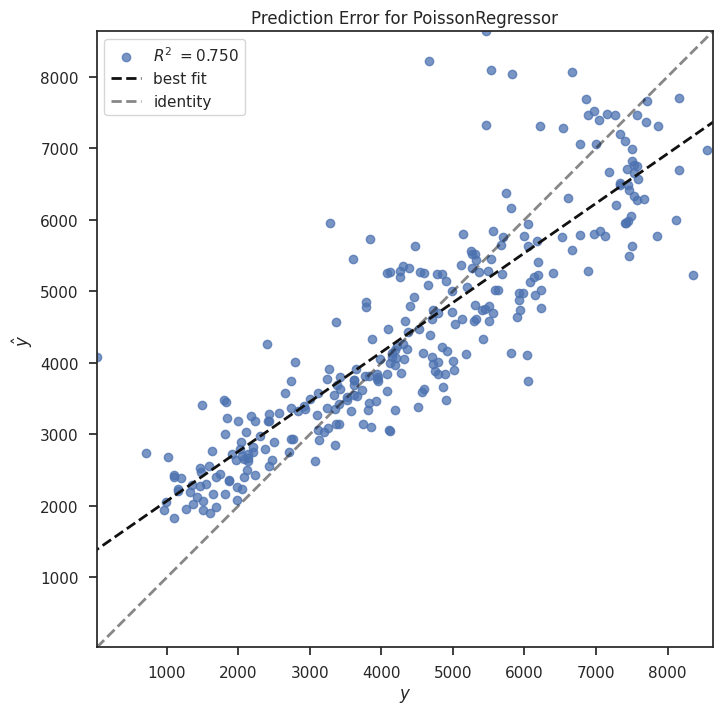

In [16]:
pr = PoissonRegressor(alpha=50).fit(x_train_fold,y_train_fold)
plt.figure(figsize=(8,8))
visualizer = prediction_error(pr, X_test, y_test, is_fitted=True)

**d) A veces el modelo que parece adecuado no lo es tanto después de todo. Ajustad una regresión lineal a los datos y calculad la calidad del modelo empleando validación cruzada
y con los datos de test.**

In [17]:
cross_val_metrics = pd.DataFrame(columns=['MSE', 'norm_MSE', 'R2'])

kf = KFold(n_splits=5)
i=1
for train_index, test_index in kf.split(X_train):
    
    x_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    x_test_fold = X_train.values[test_index,:]
    y_test_fold = y_train.values[test_index]
    
    lr = LinearRegression().fit(x_train_fold,y_train_fold)
    y_pred_fold = lr.predict(x_test_fold)
    fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
    fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
    fold_r2 = r2_score(y_test_fold, y_pred_fold)

    cross_val_metrics.loc[f'Fold {i}', :] = [fold_mse,fold_nmse, fold_r2]
    i+=1

In [18]:
cross_val_metrics.loc['Mean',:] = cross_val_metrics.mean()
cross_val_metrics

,MSE,norm_MSE,R2
Fold 1,521721.569,0.149,0.851
Fold 2,950016.238,0.224,0.776
Fold 3,819199.391,0.274,0.726
Fold 4,1069330.868,0.273,0.727
Fold 5,620166.915,0.177,0.823
Mean,796086.996,0.219,0.781


* Parece que una simple regresión lineal obtiene mejores resultados que el modelo anterior, con un R2 de 0.795 el conjunto de test.

<Figure size 800x800 with 0 Axes>

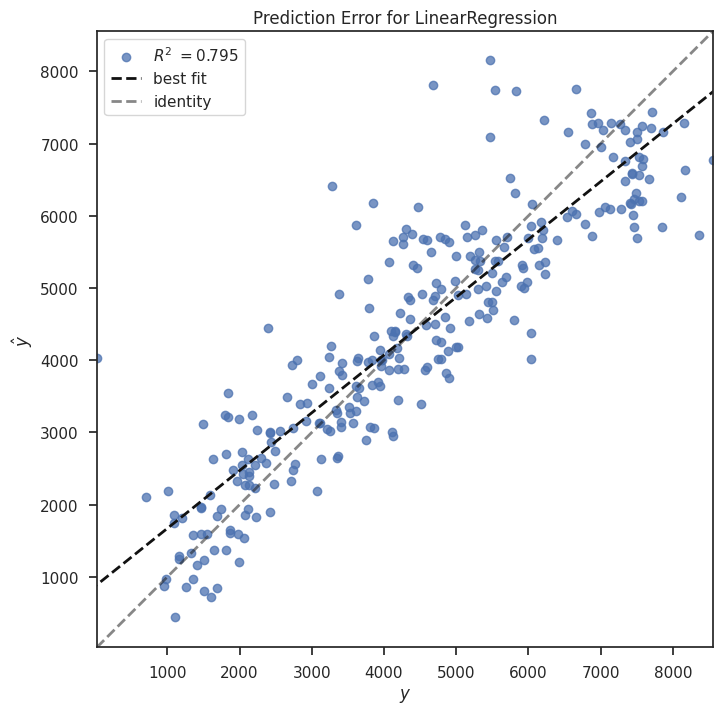

In [19]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(lr, X_test, y_test, is_fitted=True)

**e) Cuando se trata de entender un problema, es útil reducir el número de atributos en el modelo. Ajustad una regresión LASSO (ajustando la regularización usando la versión CV del
modelo) y calculad la calidad del modelo con los datos de test.**

In [20]:
lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
lasso_cv =LassoCV(alphas=lambdas,cv=5).fit(X_train,y_train)
lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train,y_train))

weights = pd.DataFrame({'lasso_cv':lasso_cv.coef_},index=X_train.columns)
print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)

Best lambda: 0.0001 R2 score: 0.780581561493265


<Figure size 800x800 with 0 Axes>

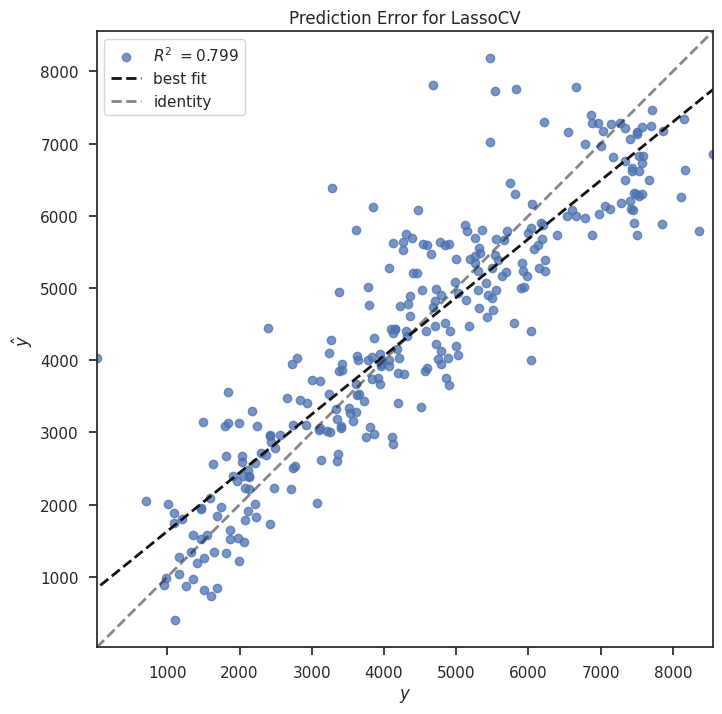

In [21]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(lasso_cv, X_test, y_test, is_fitted=True)

* Parece que el modelo LASSO es el que obtiene mejores resutados.

**f) Ahora podemos analizar y comparar los resultados:**

**- Comparad los valores pronosticados con los valores reales de los tres modelos y sus calidades. ¿Qué modelo os parece mejor? ¿Por qué?**

**- Analizad los pesos de la regresión lineal y LASSO. ¿Qué atributos son más importantes? ¿Hay atributos que no son relevantes?**


**- Comparad las predicciones de la regresión de Poisson y la regresión de LASSO. ¿Hay alguna diferencia en su comportamiento? ¿Qué creéis que está pasando?**

* El mejor modelo parece ser LASSO, ya que ha obtenido el mejor R2 entre todos los modelos, aunque la Regresión Lineal, siendo más simple, obtiene un resultado muy similar.

In [22]:
weights = pd.DataFrame({'lr':lr.coef_, 'pr':pr.coef_,'lasso_cv':lasso_cv.coef_},index=X_train.columns)

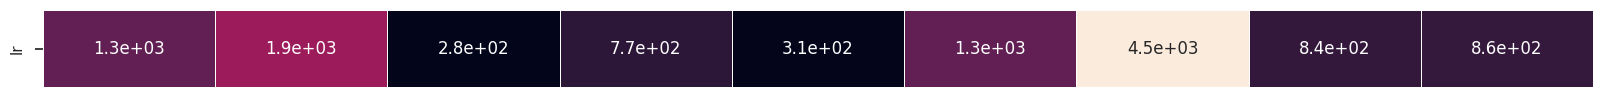

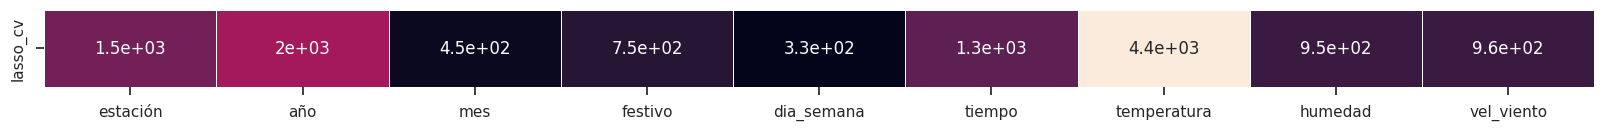

In [23]:
fig,  ax = plt.subplots( figsize = (20,1));
sns.heatmap(weights.T.loc[['lr'],:].abs(),annot=True, linewidths=.5,ax=ax,cbar=False,xticklabels=False);

plt.figure(figsize = (20,1));
sns.heatmap(weights.T.loc[['lasso_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=True);

* Vemos que los pesos en ambos casos son muy similares. Aun así, vemos que LASSO da más importancia al mes y a la humedad y vel_viento. No vemos ningún peso que sea ínfimo, no hay atributos irrelevantes. Los atributos más importantes son festivo, humedad y vel_viento, temperatura también es bastante importante.

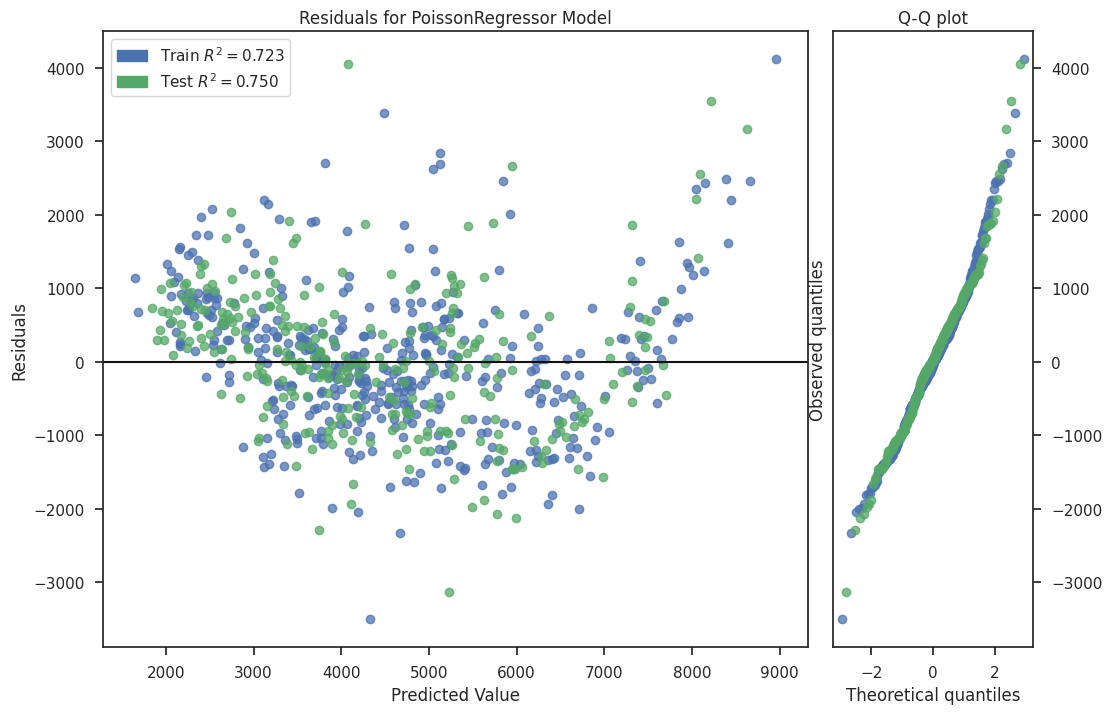

In [24]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(pr, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

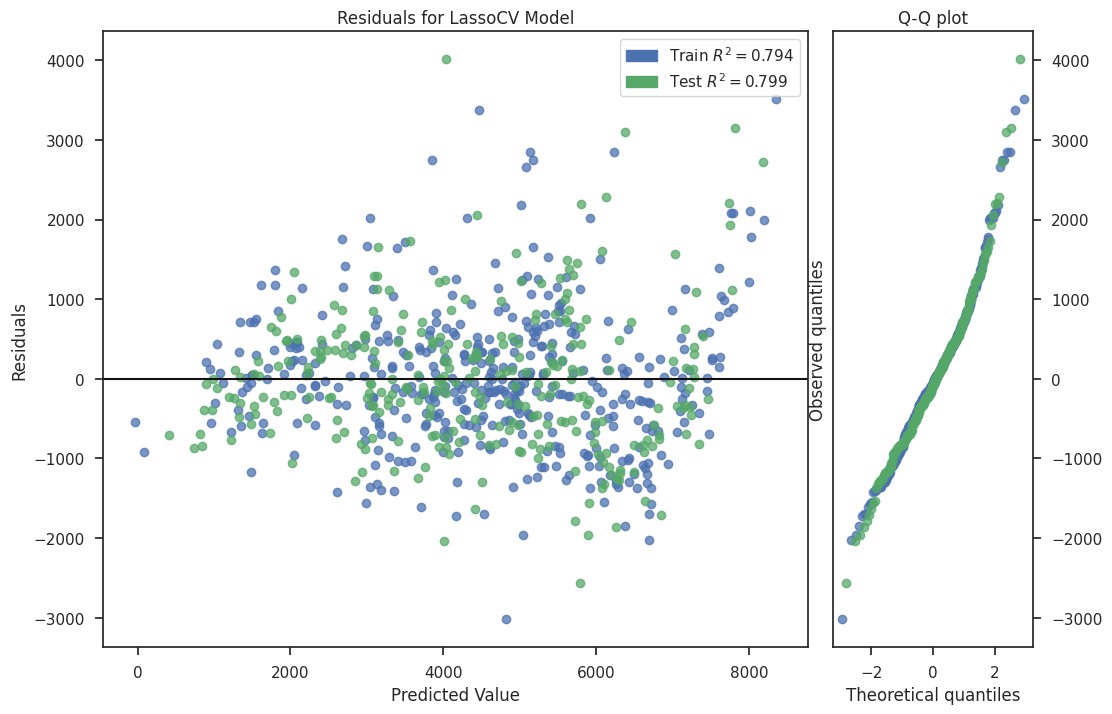

In [25]:
plt.figure(figsize=(12,8));
viz = residuals_plot(lasso_cv, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

* Si comparamos los residuos de los dos modelos en el entrenamiento y en el test, vemos que los residuos parecen mejor distribuidos en el caso de LASSO. Si vemos los pesos de la regresión de Poisson, vemos que asigna pesos muy bajos al mes y a la humedad, dando la mayor importancia a la temperatura. Si comparamos con LASSO vemos que la humedad era el atributo (junto con vel_viento) con más peso de la regresión. La distribución de pesos tan distinta provoca la diferencia entre las predicciones de los dos modelos.

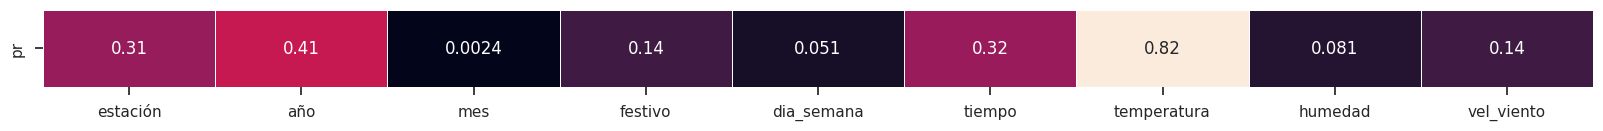

In [26]:
plt.figure(figsize = (20,1));
sns.heatmap(weights.T.loc[['pr'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=True);